In [1]:
%matplotlib inline
import time
import numpy as np
np.set_printoptions(formatter={'float': lambda x: format(x, '.4e')})
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits import mplot3d
from datetime import datetime

## Objective function

Consider the Rosenbrock function
$$
f(x_1, x_2, \cdots, x_{n}) = \sum_{i=1}^{n-1} 100(x_{i+1} -x_{i})^2 + (x_i-1)^2.
$$

In [2]:
def rose_fun(x):
    x = np.asarray(x)
    r = 0.
    for i in range(len(x)-1):
        r += 100*(x[i+1]-x[i]**2)**2 + (1-x[i])**2
    return r

def rose_dfun(x):
    x = np.asarray(x)
    df = np.zeros_like(x)
    for i in range(len(x)-1):
        df[i] += -400*(x[i+1]*x[i]-x[i]**3) - 2*(1-x[i])
        df[i+1] += 200*(x[i+1]-x[i]**2)
    return df

def rose(x):
    return rose_fun(x), rose_dfun(x)

## Visualize the objective function

Text(0.5, 0.92, 'rose_fun')

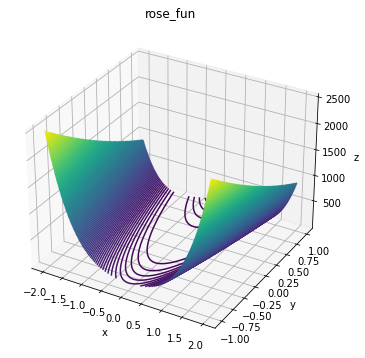

In [3]:
# this f is the name of savefig as well
f = rose_fun

# the boundary for testing
b_x = np.linspace(-2, 2, 100) 
b_y = np.linspace(-1, 1, 100)

X, Y = np.meshgrid(b_x, b_y)
# Or, change np.array as torch.tensor
Z = f(np.array([X, Y]))

fig = plt.figure(figsize=(6,6))
ax = plt.axes(projection='3d')
ax.contour3D(X, Y, Z, 150, cmap='viridis')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')
ax.set_title('{}'.format(f.__name__))

## GD, AEGD

In [4]:
def gdm(k, x, v, r, func, p):
    dt = p['dt']
    m = p['m']
    f, df = func(x)
    _v = m*v + df
    _x = x - dt*_v
    return f, _x, _v, r, df

def aegd(k, x, v, r, func, p):
    dt = p['dt']
    c = p['c']
    m = p['m']
    
    f, df = func(x)
    dg = df / (2*np.sqrt(f+c))
    
    _v = m*v + (1-m)*dg
    _r = r / (1+2*dt*_v**2)
    _x = x - 2*dt*_r*_v

    return f, _x, _v, _r, df

New

In [5]:
def aagd_m(func, xs, Gs, p, k):
    # func: [f(x), df(x)]
    # xs = [x(0), x(1), ..., x(k)]
    # Gs = [x(k-m)-eta*df(k-m), ..., x(k-1)-eta*df(k-1)] 
    # k: the current step
    # default seting: p[online = True, eta=1e-4, m=2, beta=1, gap=100, maxiter=2000, tol=1e-5]
    
    eta = p['eta']
    beta = p['beta']
    m = p['m'] # the length of the window
    Xs, x = xs[-m-1:-1], xs[-1]
    # Xs = [x(k-m), ..., x(k-1)] # x0
    # x = x(k) x1
    
    Xs = np.asarray(Xs, dtype=np.float32)
    Gs = np.asarray(Gs, dtype=np.float32)
    
    Gk = x - eta * func(x)[1] # G1
    _x = Gk # x2
    

    freq = m if p['online'] else 1
    if k % freq == 0:
      Fs = Gs - Xs # Fs = [-eta*df(k-m), ..., -eta*df(k-1)] 
      Fk = Gk - x # F1
      # using QR decomposition to solve the least-square problem
      # [df(k)-df(k-m), ..., df(k)-df(k-1)] * theta = df(k)
      # refer Wikipedia/Anderson acceleration
      theta = np.linalg.lstsq((Fk - Fs).T, Fk, rcond=None)[0]
      x_ext = (1-beta) * (x + theta @ (Xs-x)) + beta * (Gk + theta @ (Gs-Gk))
      _x = x_ext
    
    return _x, Gk

New

In [6]:
def aaegd_m(func, xs, Gs, r, p, k):
    # func: [f(x), df(x)]
    # xs = [x(0), x(1), ..., x(k)]
    # Gs = [x(k-m)-eta*df(k-m), ..., x(k-1)-eta*df(k-1)] 
    # k: the current step
    # default seting: p[online = True, eta=1e-4, m=2, beta=1, gap=100, maxiter=2000, tol=1e-5]
    
    eta = p['eta']
    beta = p['beta']
    m = p['m'] # the length of the window
    Xs, x = xs[-m-1:-1], xs[-1]
    # Xs = [x(k-m), ..., x(k-1)] # x0
    # x = x(k) x1
    
    Xs = np.asarray(Xs, dtype=np.float32)
    Gs = np.asarray(Gs, dtype=np.float32)
    
    # AEGD, c=1
    v = func(x)[1] / (2*np.sqrt(func(x)[0] + 1))
    _r = r / (1 + 2*eta * v**2)
    Gk = x - 2*eta * _r * v  # G1
    _x = Gk # x2
    

    freq = m if p['online'] else 1
    if k % freq == 0:
      Fs = Gs - Xs # Fs = [-eta*df(k-m), ..., -eta*df(k-1)] 
      Fk = Gk - x # F1
      # using QR decomposition to solve the least-square problem
      # [df(k)-df(k-m), ..., df(k)-df(k-1)] * theta = df(k)
      # refer Wikipedia/Anderson acceleration
      theta = np.linalg.lstsq((Fk - Fs).T, Fk, rcond=None)[0]
      x_ext = (1-beta) * (x + theta @ (Xs-x)) + beta * (Gk + theta @ (Gs-Gk))
      _x = x_ext
    
    return _x, Gk, _r

## runners

New

In [7]:
def runner(x0, func, optim, p):
    t = time.time()
    
    # initialization
    if optim != aegd:
        r0 = np.zeros_like(x0)
    else: #AEGD
        r0 = np.sqrt(func(x0)[0]+1) * np.ones_like(x0)

    res = dict(fs=[func(x0)[0]], xs=[x0+1e-2], rs=[r0], vs=[0], Gs=[], Fts=[])
    fs, xs, rs, vs, Gs, Fts= res['fs'], res['xs'], res['rs'], res['vs'], res['Gs'], res['Fts']
    
    k = 1
    xs.append(x0)
    
    
    while np.linalg.norm(xs[-1]-xs[-2]) > p['tol']*(1+np.linalg.norm(xs[-2])) and k < p['maxiter']:
        f, x, v, r, grad = optim(k, xs[-1], vs[-1], rs[-1], func, p)
        fs.append(f)
        xs.append(x)
        rs.append(r)
        vs.append(v)

        if k % p['gap'] == 0:
            print('[{:4}], f: {:.4e}, grad: {}'.format(k, f, grad[:2]))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k-1))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1][:2]))
        
    return res, p, elapsed

New

In [8]:
def runner_on(func, x0, optim, p):
    t = time.time()
    
    f, df = func(x0)

    # initialization
    if optim != aaegd_m:
        # AA-GD_m
        res = dict(fs=[f], Gs=[x0 - p['eta'] * (df)], xs=[x0, x0 - p['eta'] * (df)]) 
        fs, Gs, xs = res['fs'], res['Gs'], res['xs']
    else: # AA-AEGD_m
        r0 = np.sqrt(f+1) * np.ones_like(x0)
        # v1 = df / (2*np.sqrt(f+1))
        # r1 = r0 / (1 + 2*p['eta'] * v1**2)
        # x1 = x0 - 2*p['eta'] * r1 * v1

        res = dict(fs=[f], Gs=[x0], xs=[x0+1e-2, x0], rs=[r0]) 
        fs, Gs, xs, rs = res['fs'], res['Gs'], res['xs'], res['rs']
    
    k = 1
    while np.linalg.norm(xs[-1]-xs[-2]) > p['tol']*(1+np.linalg.norm(xs[-2])) and k < p['maxiter']:
    #while abs(fs[-1]-1) > p['tol'] and k < p['maxiter']: 

        if optim != aaegd_m:
            # AAGD_m
            # compute x(k+1)
            x, Gk = optim(func, xs, Gs, p, k) 
            # Update xs, Gs
            if k >= p['m']:
                #xs = xs[1:]
                Gs = Gs[1:]

        else: # AA-AEGD_m
            # compute x(k+1)
            x, Gk, r = optim(func, xs, Gs, rs[-1], p, k) 
            # Update xs, Gs
            if k >= p['m']:
                #xs = xs[1:]
                Gs = Gs[1:]
            rs[-1] = r #

        xs.append(x) # 
        Gs.append(Gk) # 
        f, df = func(x)
        fs.append(f)

        if k % p['gap'] == 0:
            print('[{:}], f: {:.4e}, |df|:{:.4e}'.format(k, f, np.linalg.norm(df)))
        k += 1
    
    elapsed = time.time() - t
    print('------------------')
    print('iterations: {}'.format(k))
    print('solution time: {:.4f}s'.format(elapsed))
    print('current function value: {}'.format(fs[-1]))
    print('current parameter value: {}'.format(xs[-1][:2]))
        
    return res


## 2-D

In [9]:
x0_2 = np.array([1.5,-0.5]) #np.ones(2)
f_r2 = rose

In [10]:
gd_2 = runner(x0_2, func=f_r2, optim=gdm,
               p=dict(dt=2e-3, m=0, gap=100, maxiter=10000, tol=1e-6))#

[ 100], f: 3.2808e+00, grad: [-1.0003e+00 1.6175e+00]
[ 200], f: 2.4988e+00, grad: [-1.3492e+00 1.5622e+00]
[ 300], f: 1.5628e+00, grad: [-1.9923e+00 1.0155e+00]
[ 400], f: 7.3300e-01, grad: [-1.5838e+00 -4.4366e-01]
[ 500], f: 3.9522e-01, grad: [-8.0673e-01 -6.0361e-01]
[ 600], f: 2.5173e-01, grad: [-5.0069e-01 -5.0261e-01]
[ 700], f: 1.7443e-01, grad: [-3.5258e-01 -4.1320e-01]
[ 800], f: 1.2689e-01, grad: [-2.6673e-01 -3.4528e-01]
[ 900], f: 9.5277e-02, grad: [-2.1105e-01 -2.9319e-01]
[1000], f: 7.3154e-02, grad: [-1.7215e-01 -2.5225e-01]
[1100], f: 5.7105e-02, grad: [-1.4352e-01 -2.1931e-01]
[1200], f: 4.5151e-02, grad: [-1.2163e-01 -1.9227e-01]
[1300], f: 3.6064e-02, grad: [-1.0439e-01 -1.6972e-01]
[1400], f: 2.9045e-02, grad: [-9.0509e-02 -1.5065e-01]
[1500], f: 2.3552e-02, grad: [-7.9117e-02 -1.3436e-01]
[1600], f: 1.9209e-02, grad: [-6.9627e-02 -1.2031e-01]
[1700], f: 1.5743e-02, grad: [-6.1624e-02 -1.0809e-01]
[1800], f: 1.2956e-02, grad: [-5.4802e-02 -9.7396e-02]
[1900], f: 1.

In [11]:
gdm_2 = runner(x0_2, func=f_r2, optim=gdm,
               p=dict(dt=7e-4, m=0.9, gap=100, maxiter=10000, tol=1e-6))#

[ 100], f: 2.0860e-02, grad: [-2.4714e+00 1.2708e+00]
[ 200], f: 8.3836e-03, grad: [-2.4842e-02 -8.6994e-02]
[ 300], f: 4.3454e-03, grad: [-2.9309e-02 -5.4819e-02]
[ 400], f: 2.3078e-03, grad: [-2.0694e-02 -3.9550e-02]
[ 500], f: 1.2459e-03, grad: [-1.4897e-02 -2.8836e-02]
[ 600], f: 6.8027e-04, grad: [-1.0847e-02 -2.1189e-02]
[ 700], f: 3.7446e-04, grad: [-7.9617e-03 -1.5657e-02]
[ 800], f: 2.0733e-04, grad: [-5.8778e-03 -1.1615e-02]
[ 900], f: 1.1528e-04, grad: [-4.3576e-03 -8.6420e-03]
[1000], f: 6.4298e-05, grad: [-3.2404e-03 -6.4435e-03]
[1100], f: 3.5946e-05, grad: [-2.4151e-03 -4.8119e-03]
[1200], f: 2.0129e-05, grad: [-1.8030e-03 -3.5976e-03]
[1300], f: 1.1287e-05, grad: [-1.3477e-03 -2.6921e-03]
[1400], f: 6.3346e-06, grad: [-1.0083e-03 -2.0158e-03]
[1500], f: 3.5578e-06, grad: [-7.5491e-04 -1.5101e-03]
[1600], f: 1.9992e-06, grad: [-5.6548e-04 -1.1317e-03]
[1700], f: 1.1239e-06, grad: [-4.2374e-04 -8.4831e-04]
[1800], f: 6.3198e-07, grad: [-3.1762e-04 -6.3603e-04]
[1900], f: 

In [12]:
aegd_2 = runner(x0_2, func=f_r2, optim=aegd,
                p=dict(dt=7.78e-4, c=1, m=0, gap=200, maxiter=10000, tol=1e-6))#

[ 200], f: 6.0161e-02, grad: [-4.0777e-01 -5.4819e-02]
[ 400], f: 3.0359e-02, grad: [-2.4245e-01 -6.4161e-02]
[ 600], f: 1.7481e-02, grad: [-1.3964e+00 6.5388e-01]
[ 800], f: 9.2576e-03, grad: [-1.3070e-01 -3.4135e-02]
[1000], f: 5.3783e-03, grad: [-3.4567e-01 1.0756e-01]
[1200], f: 3.1733e-03, grad: [-1.1572e-01 1.6183e-03]
[1400], f: 1.9139e-03, grad: [-5.7300e-02 -1.5781e-02]
[1600], f: 1.1595e-03, grad: [-4.4830e-02 -1.2041e-02]
[1800], f: 7.0518e-04, grad: [-6.1675e-02 4.4001e-03]
[2000], f: 1.4754e-03, grad: [-1.2923e+00 6.3842e-01]
[2200], f: 2.6840e-04, grad: [-4.2320e-02 4.8583e-03]
[2400], f: 1.6687e-04, grad: [-1.7048e-02 -4.4492e-03]
[2600], f: 1.0397e-04, grad: [-1.2929e-02 -3.7691e-03]
[2800], f: 6.4839e-05, grad: [-1.0157e-02 -2.9967e-03]
[3000], f: 4.0461e-05, grad: [-8.0082e-03 -2.3708e-03]
[3200], f: 2.5262e-05, grad: [-6.3205e-03 -1.8744e-03]
[3400], f: 1.5779e-05, grad: [-4.9912e-03 -1.4819e-03]
[3600], f: 9.8591e-06, grad: [-3.9430e-03 -1.1715e-03]
[3800], f: 6.161

In [13]:
aagd_m_2 = runner_on(func=f_r2, x0=x0_2, optim=aagd_m, 
                    p=dict(online = True, eta=1.9e-4, m=3, beta=1, gap=100, maxiter=10000, tol=1e-6))

------------------
iterations: 74
solution time: 0.0032s
current function value: 3.109552020393467e-08
current parameter value: [9.9985e-01 9.9970e-01]


In [14]:
aaegd_m_2 = runner_on(func=f_r2, x0=x0_2, optim=aaegd_m, 
                    p=dict(online = True, eta=6.4e-3, m=3, beta=1, gap=100, maxiter=10000, tol=1e-6))

------------------
iterations: 20
solution time: 0.0016s
current function value: 1.233041806143901e-09
current parameter value: [1.0000e+00 1.0001e+00]


### Experiment: 2D non-convex AEGD, AGEM and AA-AEGD

/var/folders/__/fd_m_zqx0pv8t0hgld1f6tmh0000gn/T/ipykernel_23761/1088667516.py:12: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([0,40000])


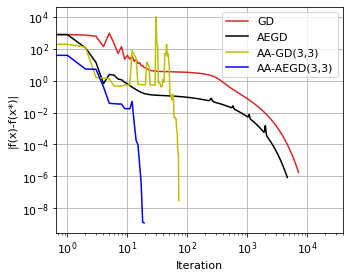

In [29]:
plt.figure(1, figsize=(5,4))

plt.plot(range(len(gd_2[0]['fs'])), gd_2[0]['fs'] - f(minima), color='#d62728', label='GD')
# plt.plot(range(len(gdm_2[0]['fs'])), gdm_2[0]['fs'] - f(minima), color='#2ca02c', label='GDM')
plt.plot(range(len(aegd_2[0]['fs'])), aegd_2[0]['fs'] - f(minima), color='k', label='AEGD')
plt.plot(range(len(aagd_m_2['fs'])), aagd_m_2['fs'] - f(minima), color='y', label='AA-GD(3,3)')
plt.plot(range(len(aaegd_m_2['fs'])), aaegd_m_2['fs'] - f(minima), color='b', label='AA-AEGD(3,3)')

plt.rcParams.update({'font.size': 11})
plt.yscale('log')
plt.xscale('log')
plt.xlim([0,40000])
plt.xlabel('Iteration')
plt.ylabel('|f(x)-f(x*)|')
plt.grid()
plt.legend(loc=0, prop={'size': 11})

plt.tight_layout()
plt.savefig('plot/2Drosen_loss.png', dpi=300)